# 1 Multi-Layer Perceptron

## 1.1 Data

Loading the dataset

In [1]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt

data = datasets.load_digits(return_X_y=True)
(inputs, targets) = data

print(targets[0:20])

[0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9]


Plotting first two images in the dataset

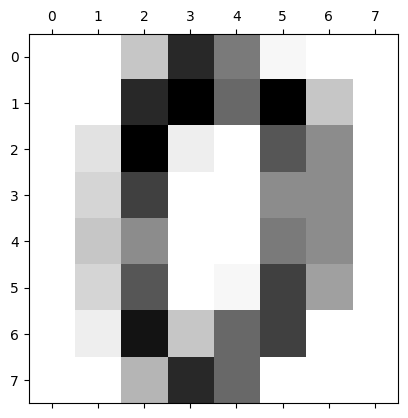

In [2]:
input0_plotting = inputs[0].reshape(8,8)
input1_plotting = inputs[1].reshape(8,8)

# first image in the dataset
fig0, ax0 = plt.subplots()
ax0.matshow(input0_plotting, cmap="Greys")
plt.show()

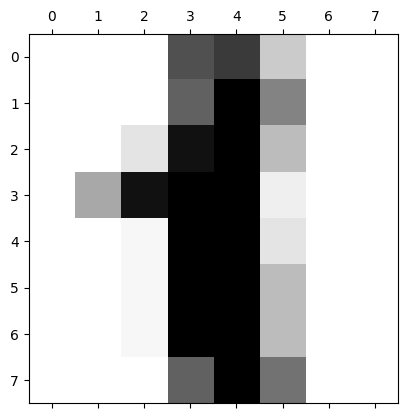

In [3]:
# second image in the dataset
fig1, ax1 = plt.subplots()
ax1.matshow(input1_plotting, cmap="Greys")
plt.show()

Reshape images to shape (64)

In [4]:
inputs[0].shape
# we see that the images already have shape (64)

(64,)

Make sure the images are represented as float32 values within either [0 to 1] or [-1 to 1] range

In [5]:
type(inputs[0,0])

numpy.float64

In [6]:
# as pixel values seem to be represented as float64 values, we cast them to float32 values.
inputs = inputs.astype("float32")

In [7]:
print(np.min(inputs), np.max(inputs))

0.0 16.0


In [8]:
# we see that the minimum is fine, but the maximum is >1, so we rescale the
# inputs to range [0 to 1]
inputs = (inputs-np.min(inputs))/(np.max(inputs)-np.min(inputs))

One-hot encode the target digits (e.g. the target digit 2 would be represented as [0,0,1,0,0,0,0,0,0,0], 9 as [0,0,0,0,0,0,0,0,0,9]). Onehot encoded vectors should have the shape (10) or (1,10) up to your preference

In [9]:
one_hots = np.eye(N=10)
targets_oh = np.array(list(map(lambda target: one_hots[target], targets)))

Write a generator function, which shuffles the (input, target) pairs (keeping the respective input and target together).

Adjust your generator function to create minibatches.

In [10]:
def shuffle_and_batch_data(inputs, targets, minibatch_size):
    # create an index vector
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)

    # shuffle inputs and targets
    shuffled_inputs = inputs[indices]
    shuffled_targets = targets[indices]

    # calculate the number of minibatches
    num_minibatches = len(inputs) // minibatch_size

    for i in range(num_minibatches):
      # calculate the indices delimiting the current minibatch
      start_idx = i * minibatch_size
      end_idx = (i + 1) * minibatch_size

      # bundle training examples into minibatches
      minibatch_inputs = shuffled_inputs[start_idx:end_idx]
      minibatch_targets = shuffled_targets[start_idx:end_idx]

      yield minibatch_inputs, minibatch_targets

## 1.2 Sigmoid Activation Function

Implement the Sigmoid Activation Function as an object with a call function (we will later add a backwards function for backpropagation, this being the reason its implemented as an object). It should expect inputs as ndarrays of shape minibatchsize, num units.

In [11]:
class Sigmoid():
  def __call__(self, pre_act):
    return np.exp(pre_act) / (1 + np.exp(pre_act))

## 1.3 Softmax Activation Function
Implement the the softmax in Numpy, again as an object with a call function, which expects inputs of size minibatchsize,10 [because there are 10 neurons in the output layer], where each 1,10 subelement represents a vector as discussed above

In [12]:
class Softmax():

    def __call__(self, pre_acts):

        # for each of the samples in the minibatch the sum of the preactivations of the last layer has to be calculated, so axis=1 since per row
        sum_of_preactivations = pre_acts.sum(axis=1).reshape(pre_acts.shape[0],1) # shape = (minibatchsize,1)

        list_outputs=[]
        # each output of each sample in the minibatch is divided by the sum of all outputs in their sample and stored in a list
        for z_i, sum_z_j in zip(pre_acts, sum_of_preactivations):
            list_outputs.append(z_i/sum_z_j)

        activations = np.array(list_outputs).reshape(pre_acts.shape)
        return activations

## 1.4 Weights

Implement a class representing an MLP layer. The constructor should specify the activation function (Sigmoid or Softmax as implemented above), as well as the number of units (Perceptrons) in this layer, and the input size (number of units in the preceding layer). It should create attributes for the weight matrix and a bias vector (or absorb the bias vector into the weight matrix as discussed in the lecture, depending on your preference). Initialize the weights as small random values (e.g. from a normal distribution with μ = 0., σ = 0.2), and bias values set to zero.
Implement a forward function, which accepts an input of shape minibatchsize, input size, and outputs an ndarray of shape minibatchsize,num units after applying the
weight matrix, the bias and the activation function.

In [13]:
class Layer():

  def __init__(self, layer_size, input_size, act_func):
    self.layer_size = layer_size
    self.input_size = input_size
    self.act_func = act_func

    self.weights = np.random.normal(0., 0.2, size=(self.input_size, self.layer_size))
    self.biases = np.zeros((1,self.layer_size))

    self.activation_prevL = None # value set in __call__(); used in backwards()

  def __call__(self, inputs):
    self.activation_prevL = inputs
    return inputs@self.weights + self.biases   # this is the preactivation

## 1.5 Putting together the MLP

Implement a class representing a full MLP. You should be able to specify the number of layers, as well as the size of each layer separately in the constructor. Remember the initial input will be shaped minibatchsize,64, the final output will be shaped minibatchsize, 10. The MLP should have an attribute, which is a list of all the MLP layers it contains.


In [14]:
class MLP():

  def __init__(self, number_layers, input_layer_size, layer_sizes):
    self.number_layers = number_layers
    self.layer_sizes = layer_sizes

    self.preactivations = [] # populated in call(), used in backwards()
    self.activations = [] # populated in call(), used in backwards()
    self.losses = [] # populated and used in backwards()

    layers_list = []
    for i in range(self.number_layers):
      # input size is the size of the previous layer. this holds for all layers except for the first, where the size of the previous layer is the input size.
      if (i == 0):
        number_inputs = input_layer_size
      else:
        number_inputs = layer_sizes[i-1]
      # activation function is Sigmoid for all layers except for the last, where it is Softmax
      if (i == self.number_layers-1):
        act_function = Softmax()
      else:
        act_function = Sigmoid()
      layers_list.append(
        Layer(
          layer_size = layer_sizes[i],
          input_size = number_inputs,
          act_func = act_function
        )
      )
    self.layers = layers_list

  def __call__(self, input):
    for i, layer in enumerate(self.layers):
      preactivation = layer(self.activations[i-1] if i>0 else input)
      self.preactivations.append(preactivation)
      self.activations.append(layer.act_func(preactivation))
    return self.activations[-1]

## 1.6 CCE Loss Function

Implement a categorical cross-entropy loss function for your network. Again, implement it as an object with a call function for the function itself (which again is extended with a backwards function later).

In [15]:
class CCE_Loss():
  def __call__(self, prediction, target):
    # first, since ln(x) is undefined for negative x, we need to turn negative activation values in the output layer into positive values while retaining the original activation values' distance to the corresponding target
    for j, training_example in enumerate(prediction):  # go through all training examples in the minibatch
      for i, activation in enumerate(training_example): # go through all output neuron activations the MLP produced for the current training example
        if activation < 0:
          training_example[i] = target[j,i]+np.abs(target[j,i]+activation)

    return -np.sum(target * np.log(prediction), axis=1) # this returns a plain number for each minibatch (ie, an array of shape (minibatch_size,)).

## Testing

In [16]:
number_layers = 2
input_layer_size = 64
layers_sizes = [10, 10]
test = MLP(number_layers, input_layer_size, layers_sizes)

minibatch_size = 2
test_output = test(inputs[0:minibatch_size])

In [17]:
print(test_output.shape == (minibatch_size, 10))
test_output

True


array([[ 0.03167827, -7.30477917,  1.21507944,  2.71649263,  4.87067585,
         6.3185848 , -2.85777045,  3.17683445, -4.62555203, -2.54124379],
       [ 0.32006645, -1.84317855,  0.14510835,  0.60646536,  0.86617059,
         1.67858057, -0.43167617,  0.84455669, -0.71878625, -0.46730703]])

In [18]:
print(targets_oh[0:minibatch_size])

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [25]:
compute_loss = CCE_Loss()
test_loss = compute_loss(prediction=test_output, target=targets_oh[0:minibatch_size])

# 2 Backpropagation

## 3.1 CCE – Backwards

In [20]:
def backwards(self, y_hat, target):
  # y_hat, prediction, shape: (minibatchsize, 10)
  # target, shape: (minibatchsize, 10)
  # return: error signal, shape: (minibatchsize, 10)
  #         containing values of error signal dL_CCE/dy_hat_i for each sample in the minibatch
  dL_dyhat = target / (np.log(2)*y_hat)

  return dL_dyhat # error signal, shape: (minibatchsize, 10)

CCE_Loss.backwards = backwards

## 3.2 Sigmoid – Backwards

In [21]:
def sigmoid_dash(self, x): # d a / d pre_a
  return self.call(x) * (1 - self.call(x))

def backwards(self, prea, dL_da): # dL_da = error signal up to this point in the ANN from the back

  #  for all samples of the minibatch calculating d a / d pre_a
  da_dprea = self.sigmoid_dash(prea)

  # calculating d L / d pre_a
  # by using the two partial derivatives: d L / d a and d a / d pre_a
  # for each sample for each unit the partial derivatives have to be multiplied separately
  dL_dprea = dL_da * da_dprea # matrices of same shape: multiplication of values at same position

  # for each of the samples in the minibatch (one sample per row)
  # in the columns are the error signals up to the preactivations of this layers units
  # (column 1: preactivation error signal for unit 1)
  return dL_dprea # shape: (minibatchsize, num_units)

Sigmoid.sigmoid_dash = sigmoid_dash
Sigmoid.backwards = backwards

## 3.3 Weights – Backwards

In [22]:
def weights_backwards(self, dL_dprea, prea):
  # dL_dprea shape : (minibatchsize, num_units_currentL)
  # prea shape : (minibatchsize, num_units_currentL)

  num_units_prevL = self.input_size

  # derivating the input of each units preactivation in the current layer with respect to each previous layer unit's activation
  # thats just the weight matrix bc all other weights cut out when derivating bc they are constants
  # -> how does the preactivation change with respect to the activation of the pervious layer
  dprea_daprevL = self.weights # shape = (num_units_currentL, num_units_prevL)

  # (minibatchsize, num_units_prevL) = (minibatchsize, num_units_currentL) @ (num_units_currentL, num_units_prevL)
  # first to return
  dL_daprevL = dL_dprea @ dprea_daprevL


  a_prevL = self.activation_prevL # shape = (minibatchsize, inputsize)
  dprea_dW = a_prevL

  # second to return
  dL_dW = dL_dprea @ dprea_dW

  return (dL_daprevL, dL_dW)

Layer.weights_backwards = weights_backwards

## 3.4 Layer backwards

In [23]:
def backwards(self, layer_output, derivatives):
  my_sigmoid = Sigmoid()
  return self.weights_backwards(my_sigmoid.backwards(self.preactivations, derivatives[-1]))

Layer.backwards = backwards

## 3.5 Gradient Tape and MLP Backwards

In [24]:
def backwards(self, targets):
  # first of all, we need to compute the CCE loss
  minibatch_size = self.activations[-1].shape[0]
  compute_loss = CCE_Loss()
  self.losses.append(compute_loss(prediction=self.activations[-1], target=targets_oh[0:minibatch_size]))

  # now we can do the backwards steps
  derivatives = ["empty"] * (self.number_layers+1) # +1 since last spot is reserved for CCE derivative

  derivatives[-1] = CCE_Loss.backwards(self=compute_loss, y_hat=self.activations[-1], target=targets[-1])

  for i in range(self.number_layers):
    idx = self.number_layers-1 - i # backwards indexing
    derivatives[idx-1] = self.layers[idx].backwards(self.activations[idx], derivatives)

  return derivatives

MLP.backwards = backwards

## 3.6 Training

In [ ]:
def training(mlp, inputs, targets, num_epochs, minibatch_size, learning_rate):
    num_minibatches = len(inputs) // minibatch_size

    for epoch in range(num_epochs):

      for i in range(num_minibatches):
        # calculate the indices delimiting the current minibatch
        start_idx = i * minibatch_size
        end_idx = (i + 1) * minibatch_size

        mlp(inputs[start_idx:end_idx]) # all relevant data is stored in internal attributes

      # backwards step
      derivatives = mlp.backwards(targets)

      # update weights
      W = learning_rate * np.subtract(W, derivatives[:-1])


number_layers = 2
input_layer_size = 64
layer_sizes = [10, 10]

num_epochs = 5
minibatch_size = 30
learning_rate = 0.2

my_mlp = MLP(number_layers, input_layer_size, layer_sizes)
training(my_mlp, inputs, targets_oh, num_epochs, minibatch_size, learning_rate)

avg_losses = []
for i in range(num_epochs):
  start_idx = i * num_epochs
  end_idx = (i + 1) * num_epochs
  avg_losses.append(np.mean(my_mlp.losses[start_idx:end_idx]))

fig, ax = plt.subplots()
ax.plot(np.array(list(range(num_epochs))), np.array(avg_losses))
plt.show()

AttributeError: ignored